In [6]:
import numpy as np
import mrcfile 
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F 
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta

from PIL import Image 
from tqdm import tqdm

from scipy.ndimage import gaussian_filter

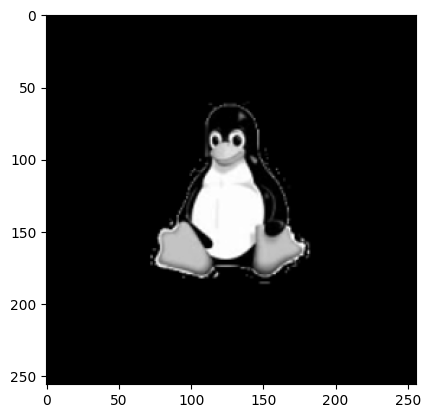

In [17]:
img = np.array(Image.open("image.png").convert('L').resize((256,256))).astype(np.float32)
plt.imshow(img,cmap='gray')

In [3]:
init = (init - init.min())/(init.max() - init.min())
init.mean()/0.2

np.float32(0.32143387)

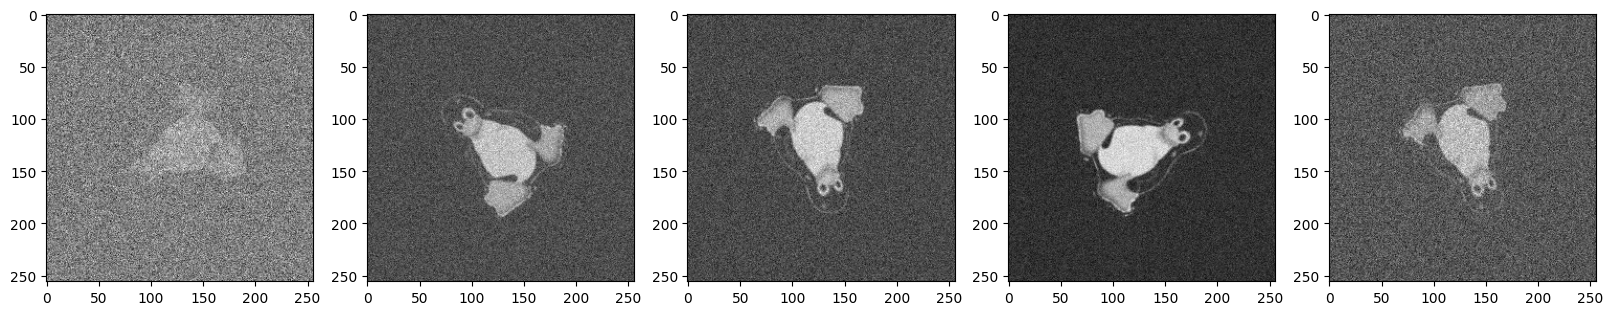

In [7]:
with mrcfile.open("data2.mrc",permissive=True) as mrc:
    data = mrc.data 

fig, ax = plt.subplots(1,5,figsize=(20,8))

for i in range(5):
    ax[i].imshow(data[np.random.randint(0,800)],cmap='gray')

In [ ]:
device = 'cuda:1'
std = torch.tensor(0.001).to(device)    
std_xy = torch.tensor(120).to(device)

with mrcfile.open("data2.mrc",permissive=True) as mrc:
    X = mrc.data

K = 10000
n = init.shape[0]
img = np.array(Image.open("image.png").convert("L").resize((256,256)))
img = img = (img - img.min())/(img.max() - img.min())
init = gaussian_filter(img, sigma=3)      
A = torch.tensor(init,dtype=torch.float32).to(device)
data = torch.tensor(X).type(torch.float32).to(device)

In [9]:
n = A.shape[0]    
batch_size = K // 10
num_batch = K // batch_size

normal_dist = MultivariateNormal(loc=torch.zeros(2).to(device), 
                                     covariance_matrix=std_xy * torch.eye(2).to(device))
uniform_dist = Uniform(0,2*torch.pi)
beta_dist = Beta(torch.tensor(2.0).to(device), torch.tensor(5.0).to(device))

A_t = torch.zeros_like(A,dtype=torch.float32).to(device)
std_t = torch.tensor(0,dtype=torch.float32).to(device)
stdxy_t = torch.tensor(0,dtype=torch.float32).to(device)
Z = torch.tensor(0, dtype=torch.float32).to(device)
indices = []

In [232]:
for i in range(1):
    X = data[60]
    integral = torch.zeros_like(A_t,dtype=torch.float32)
    std_batch = torch.tensor(0,dtype=torch.float32).to(device) 
    stdxy_batch = torch.tensor(0,dtype=torch.float32).to(device)
    Z_batch = torch.tensor(0, dtype=torch.float32).to(device)

    weights = torch.zeros((1,K))
    for j in range(num_batch):
        thetas = uniform_dist.sample((batch_size,)).to(device)
        translations = normal_dist.sample((batch_size,)).to(device)
        scales = beta_dist.sample((batch_size,)).to(device)

        thetas_logits = uniform_dist.log_prob(thetas).to(device)
        translations_logits = normal_dist.log_prob(translations).to(device)
        scales_logits = beta_dist.log_prob(scales/5.0).to(device) - torch.log(torch.tensor(5.0))

        scales = 5.0*scales

        transformations = torch.zeros((batch_size, 2, 3)).to(device)
        transformations[:, 0, 0] = torch.cos(thetas)
        transformations[:, 0, 1] = -torch.sin(thetas)
        transformations[:, 1, 0] = torch.sin(thetas)
        transformations[:, 1, 1] = torch.cos(thetas)
        transformations[:, :, 2] = 2*translations / n # PyTorch assumes translations are in [-1,1]

        grid = F.affine_grid(transformations, size=(batch_size, 1, n, n), align_corners=False)
        A_psi = F.grid_sample(A.expand(batch_size, 1, n, n), grid, align_corners=False).squeeze(1) * (scales.view(-1,1,1))

        inv_rotations = transformations[...,:2].permute(0,2,1)
        inv_t = -torch.bmm(inv_rotations,transformations[...,2:])
        inv_trans = torch.cat([inv_rotations,inv_t],dim=-1)
        inv_grid = F.affine_grid(inv_trans,size=(batch_size,1,n,n), align_corners=False) 

        X_psi = F.grid_sample(X.expand(batch_size, 1, n, n), inv_grid, align_corners=False).squeeze(1) / (scales.view(-1,1,1))

        X_log_density = -(torch.norm(X - A_psi,dim=(1,2))) ** 2 / (2*std ** 2)
        X_log_density = X_log_density - torch.logsumexp(X_log_density,0) # Stable normalization

        psi_log_density = thetas_logits + translations_logits + scales_logits
        
  
        w = torch.exp(X_log_density + psi_log_density)
        w /= w.sum()

        indices.append(X_psi[w.argmax().item()])
        Z_batch += (w * scales**2).sum()
        std_batch += ( w.view(batch_size,1,1) *(torch.norm(X - A_psi,dim=(1,2))/255) ** 2 ).sum()
        stdxy_batch += (w.view(batch_size,1,1) * (torch.norm(translations,dim=1)**2)).sum()
        integral += (w.view(batch_size, 1, 1) * X_psi * (scales**2).view(batch_size,1,1)).sum(dim=0)

        weights[0, j*batch_size:(j+1)*batch_size] = w 
    A_t += integral/K
    std_t +=  std_batch / K
    stdxy_t +=  stdxy_batch/K   
    Z += Z_batch/K
std_t /= ((n**2) * data.shape[0])
std_t = std_t ** 0.5
stdxy_t /= 2*data.shape[0]  
stdxy_t = stdxy_t ** 0.5

In [ ]:
device = 'cuda:1'
std = torch.tensor(0.01).to(device)    
std_xy = torch.tensor(5).to(device)


generate_data(800,1,5)
with mrcfile.open("data2.mrc",permissive=True) as mrc:
    X = mrc.data
                  
img = np.array(Image.open("image.png").convert("L").resize((256,256)))
img = img = (img - img.min())/(img.max() - img.min())
init = gaussian_filter(img,sigma=5)

n = init.shape[0]

A = torch.tensor(init,dtype=torch.float32).to(device)
X = torch.tensor(X).type(torch.float32).to(device)

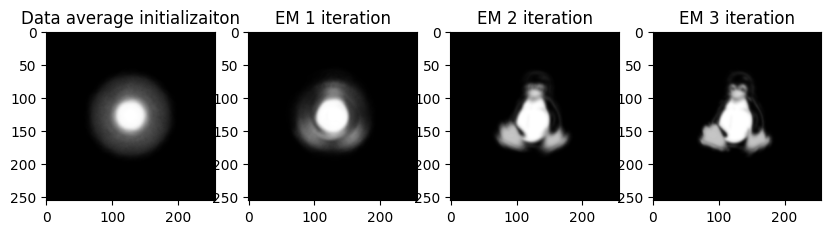

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(10,5))

ax[0].imshow(init,cmap='gray')
ax[0].set_title("Data average initializaiton")
for i in range(0,3):
    with mrcfile.open(f"experiment/{i}_iteration.mrc",permissive=True) as mrc:
        result = mrc.data 
    ax[i+1].imshow(result,cmap='gray')
    ax[i+1].set_title(f"EM {i+1} iteration")

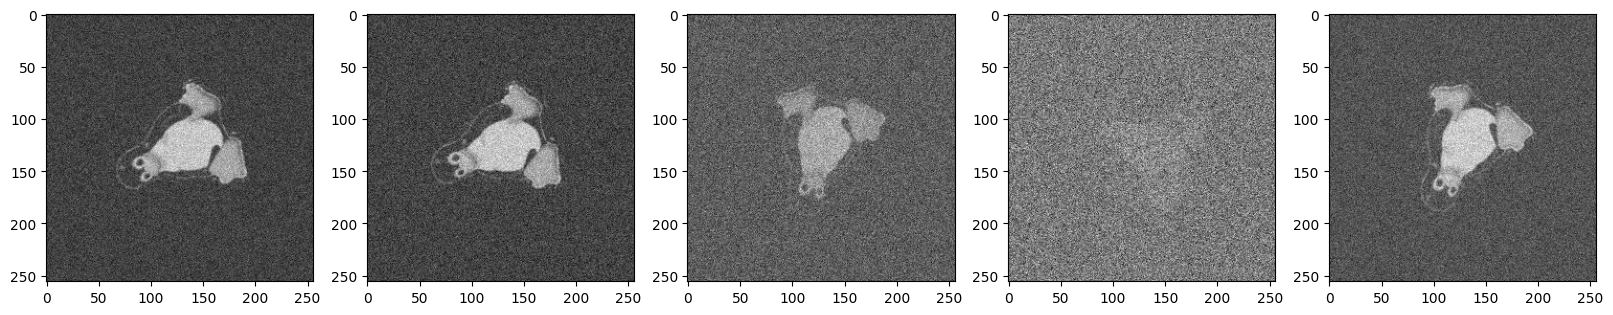

In [ ]:
with mrcfile.open("data2.mrc",permissive=True) as mrc:
    data = mrc.data 

fig, ax = plt.subplots(1,5,figsize=(20,8))

for i in range(5):
    ax[i].imshow(data[np.random.randint(0,800)],cmap='gray')

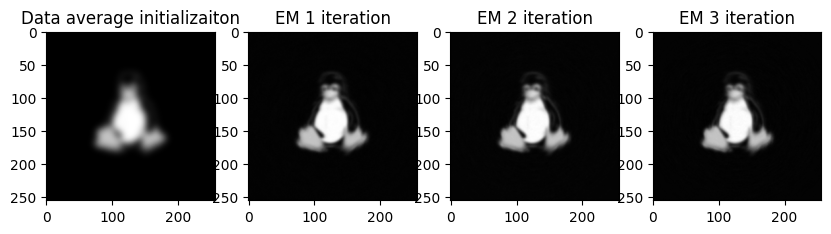

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(10,5))

img = np.array(Image.open("image.png").convert("L").resize((256,256)))
img = img = (img - img.min())/(img.max() - img.min())
init = gaussian_filter(img, sigma=5)      

ax[0].imshow(init,cmap='gray')
ax[0].set_title("Data average initializaiton")
for i in range(0,3):
    with mrcfile.open(f"std0.2/{i}_iteration.mrc",permissive=True) as mrc:
        result = mrc.data 
    ax[i+1].imshow(result,cmap='gray')
    ax[i+1].set_title(f"EM {i+1} iteration")

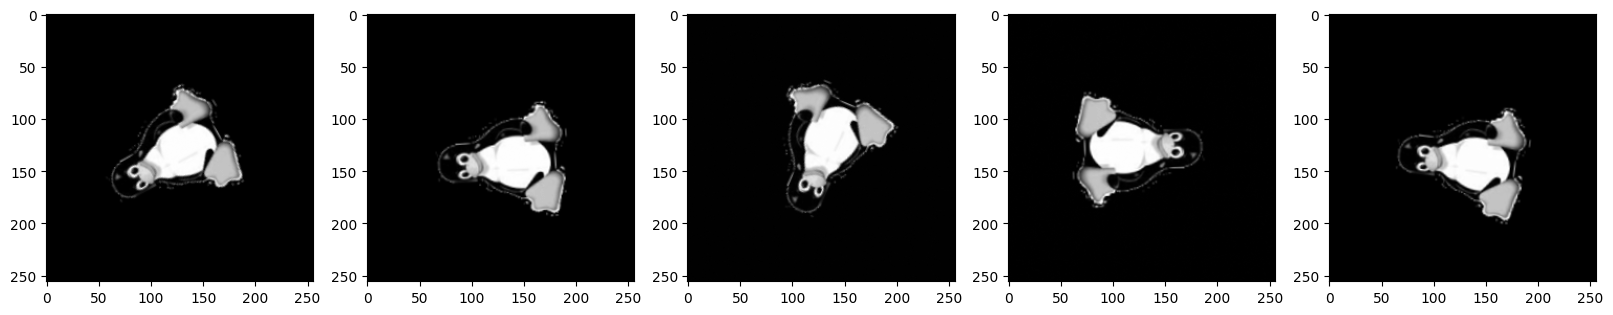

In [ ]:
with mrcfile.open("data3.mrc",permissive=True) as mrc:
    data = mrc.data 

fig, ax = plt.subplots(1,5,figsize=(20,8))

for i in range(5):
    ax[i].imshow(data[np.random.randint(0,800)],cmap='gray')

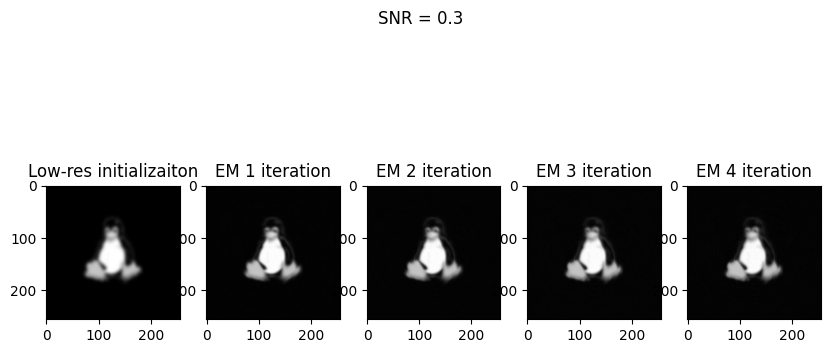

In [ ]:
fig, ax = plt.subplots(1,5,figsize=(10,5))

img = np.array(Image.open("image.png").convert("L").resize((256,256)))
img = img = (img - img.min())/(img.max() - img.min())
init = gaussian_filter(img, sigma=3)      

ax[0].imshow(init,cmap='gray')
ax[0].set_title("Low-res initializaiton")
fig.suptitle("SNR = 0.3")
for i in range(0,4):
    with mrcfile.open(f"experiment/{i}_iteration.mrc",permissive=True) as mrc:
        result = mrc.data 
    ax[i+1].imshow(result,cmap='gray')
    ax[i+1].set_title(f"EM {i+1} iteration")

In [ ]:
normal_dist = MultivariateNormal(loc=torch.zeros(2).to(device), 
                                     covariance_matrix=120 * torch.eye(2).to(device))
uniform_dist = Uniform(0,2*torch.pi)

A_t = torch.zeros_like(A,dtype=torch.float32).to(device)

A = torch.tensor(img,dtype=torch.float32).to(device)

In [ ]:
thetas = uniform_dist.sample((batch_size,)).to(device)
translations = normal_dist.sample((batch_size,)).to(device)
scales = beta_dist.sample((batch_size,)).to(device)

transformations = torch.zeros((batch_size, 2, 3)).to(device)
transformations[:, 0, 0] = torch.cos(thetas)
transformations[:, 0, 1] = -torch.sin(thetas)
transformations[:, 1, 0] = torch.sin(thetas)
transformations[:, 1, 1] = torch.cos(thetas)
transformations[:, :, 2] = 2*translations / n # PyTorch assumes translations are in [-1,1]

grid = F.affine_grid(transformations, size=(batch_size, 1, n, n), align_corners=False)
A_psi = F.grid_sample(A.expand(batch_size, 1, n, n), grid, align_corners=False).squeeze(1) * (scales.view(-1,1,1))

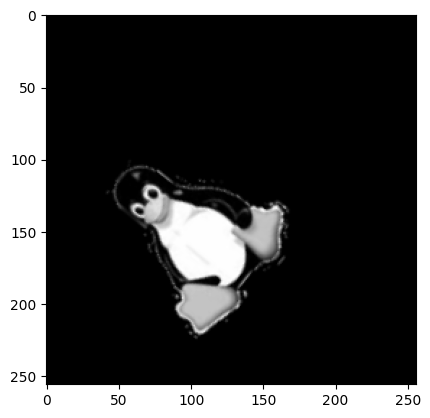

In [ ]:
plt.imshow(A_psi[141].cpu().numpy(),cmap='gray')

In [ ]:
inv_rotations = transformations[...,:2].permute(0,2,1)
inv_t = -torch.bmm(inv_rotations,transformations[...,2:])
inv_trans = torch.cat([inv_rotations,inv_t],dim=-1)
inv_grid = F.affine_grid(inv_trans,size=(batch_size,1,n,n), align_corners=False) 

X_psi = F.grid_sample(A_psi[141].expand(batch_size, 1, n, n), inv_grid, align_corners=False).squeeze(1) / (scales.view(-1,1,1))

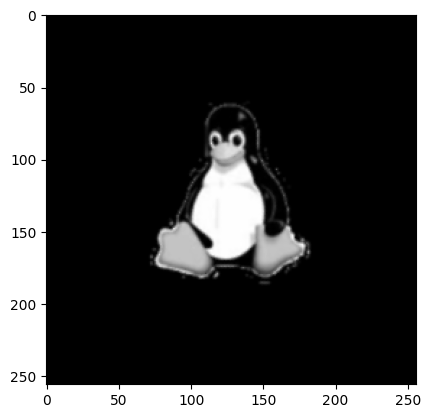

In [ ]:
plt.imshow(X_psi[141].cpu().numpy(),cmap='gray');

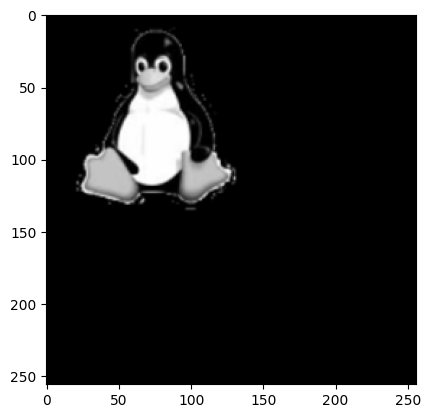

In [ ]:
A = torch.tensor(img,dtype=torch.float32).to(device)
transformations = torch.zeros((1, 2, 3)).to(device)
transformations[:, 0, 0] = 30
transformations[:, 0, 1] = 0
transformations[:, 1, 0] = 0
transformations[:, 1, 1] = 1
transformations[:, :, 2] = 0.4

grid = F.affine_grid(transformations, size=(1, 1, n, n), align_corners=False)
A_psi = F.grid_sample(A.expand(1, 1, n, n), grid, align_corners=False).squeeze(1) 
plt.imshow(A_psi.cpu().numpy()[0],cmap='gray');

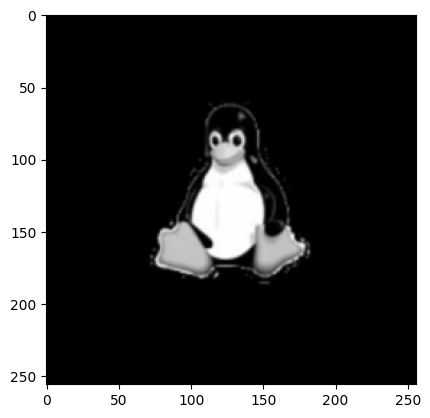

In [ ]:
inv_rotations = transformations[...,:2].permute(0,2,1)
inv_t = -torch.bmm(inv_rotations,transformations[...,2:])
inv_trans = torch.cat([inv_rotations,inv_t],dim=-1)
inv_grid = F.affine_grid(inv_trans,size=(1,1,n,n), align_corners=False) 

X_psi = F.grid_sample(A_psi.expand(1, 1, n, n) , inv_grid, align_corners=False).squeeze(1) 
plt.imshow(X_psi.cpu().numpy()[0],cmap='gray');

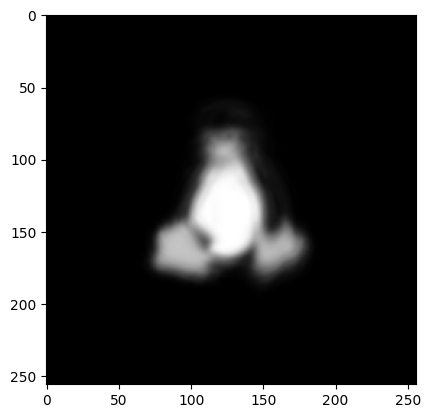

In [ ]:
with mrcfile.open("experiment/2_iteration.mrc",permissive=True) as mrc:
    r = mrc.data 

plt.imshow(r,cmap='gray')